<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EA%B3%BC%EC%A0%9C_1129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 이미지 분할(Segmentation)

- 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
- 모든 픽셀은 어떤 클래스에 속함
- 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체 분리 가능

- 의미 분할 : 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
- 인스턴스 분할 : 같은 범주에 속하더라도 서로 다른 객체를 구분

## 7-1 데이터셋 준비
- Oxford-IIIT Pet Dataset
- 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성
- 마스크 : 각 픽셀에 대한 범주 레이블

- class 1 : 반려동물이 속한 픽셀
- class 2 : 반려동물과 인접한 픽셀
- class 3 : 위에 속하지 않는 경우/주변 픽셀

In [2]:
# 영상 처리를 위한 라이브러리 불러오기
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [3]:
# 모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터 설정
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

- 주요 파라미터 정리 -> 모델의 세부 튜닝 작업 효율적으로 가능

In [ ]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.1K8JG2_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.1K8JG2_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# 이미지 전처리 함수(원본 이미지와 분할 마스크에 적용할 것)
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'], (img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [ ]:
# 데이터 전처리 파이프라인
## 앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해 주고 미니배치로 분할
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [ ]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

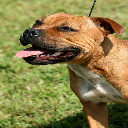

In [ ]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

In [ ]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2) * 255.0
cv2_imshow(mask)

## 7-2 U-Net 모델(인코더-디코더)

- 사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델 만들기
- 사전 학습된 모델 없이도 데이터의 개수와 시간이 충분하다면, U-Net을 구성하여 학습을 진행할 수 있음, 데이터 개수와 시간이 충분하다는 전제
- 구글 코랩 환경에서 제한된 자원으로 양호한 성능을 갖는 모델을 만들기 위해서 사전 학습된 모델을 베이스모델로 활용하는 전이 학습 방법 사용
- VGG16 모델을 최종 레이어를 제외한 채로 불러오기

In [5]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top = False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- VGG16 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조
- 인코더 : 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소, 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2 중에서 하나로 분류하는 역

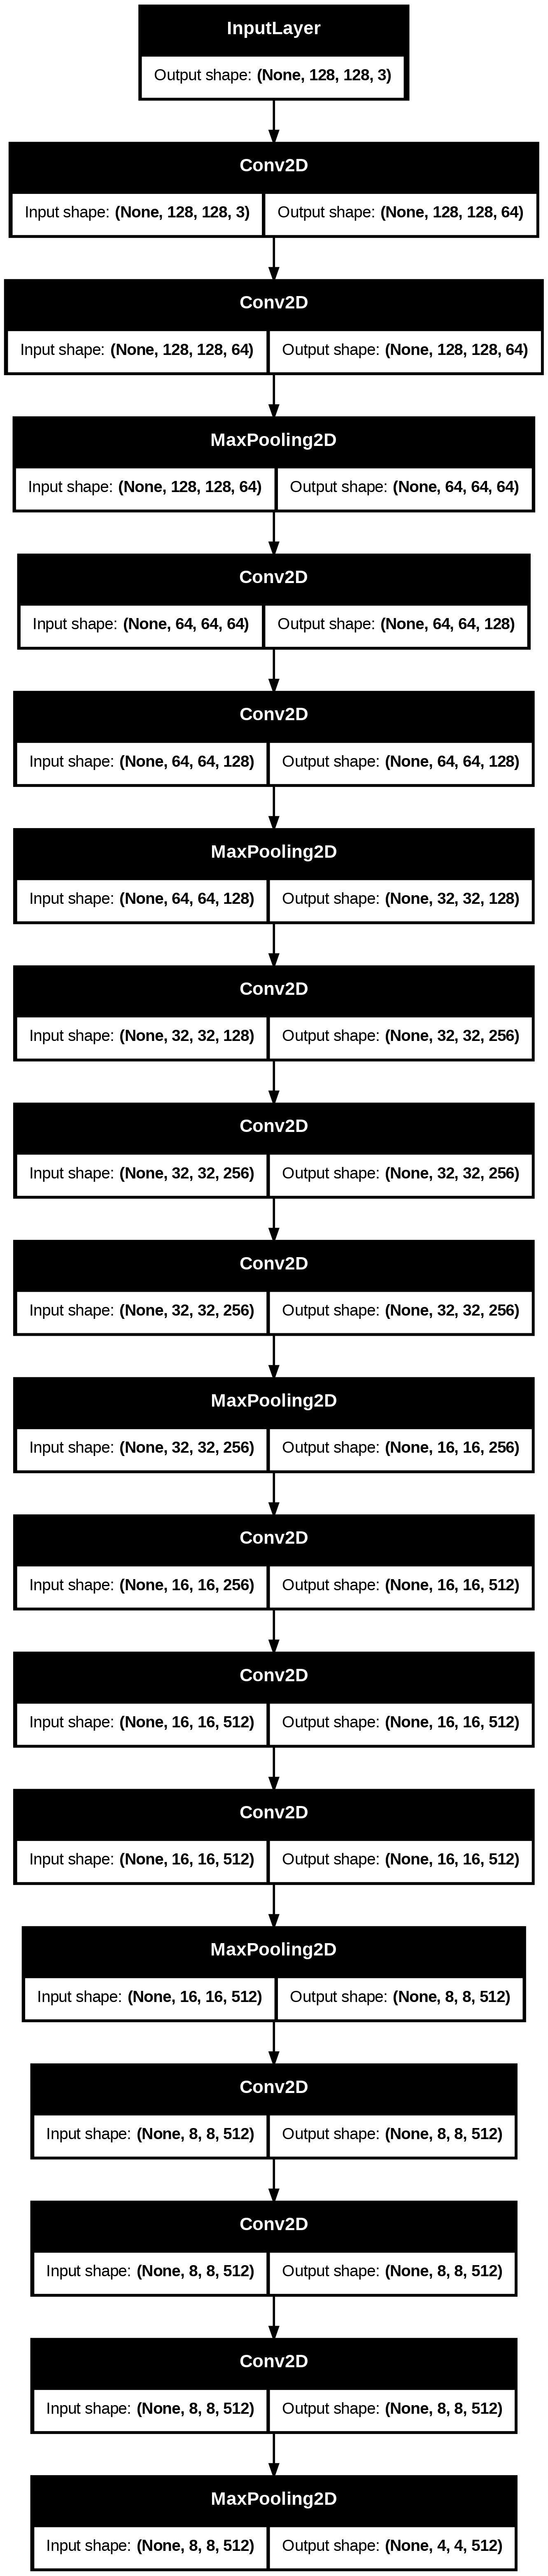

In [6]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

- 만들고자 하는 U-net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정함
- VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여 다양한 피처(특징)를 추출하는 인코더 모델의 정의

In [7]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                             base_model.get_layer(name='block5_conv3').output,
                             base_model.get_layer(name='block4_conv3').output,
                             base_model.get_layer(name='block3_conv3').output,
                             base_model.get_layer(name='block2_conv2').output,
                             base_model.get_layer(name='block1_conv2').output
                         ])

In [8]:
# 파라미터 고정
## 사전 학습된 파라미터를 인코더에 그대로 사용하기 위해 업데이트되지 않도록 고정
f_model.trainable = False

- 업샘플링 : 축소된 이미지를 원래 이미지 크기로 복원하는 과정

In [10]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3,3,activation='elu',padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

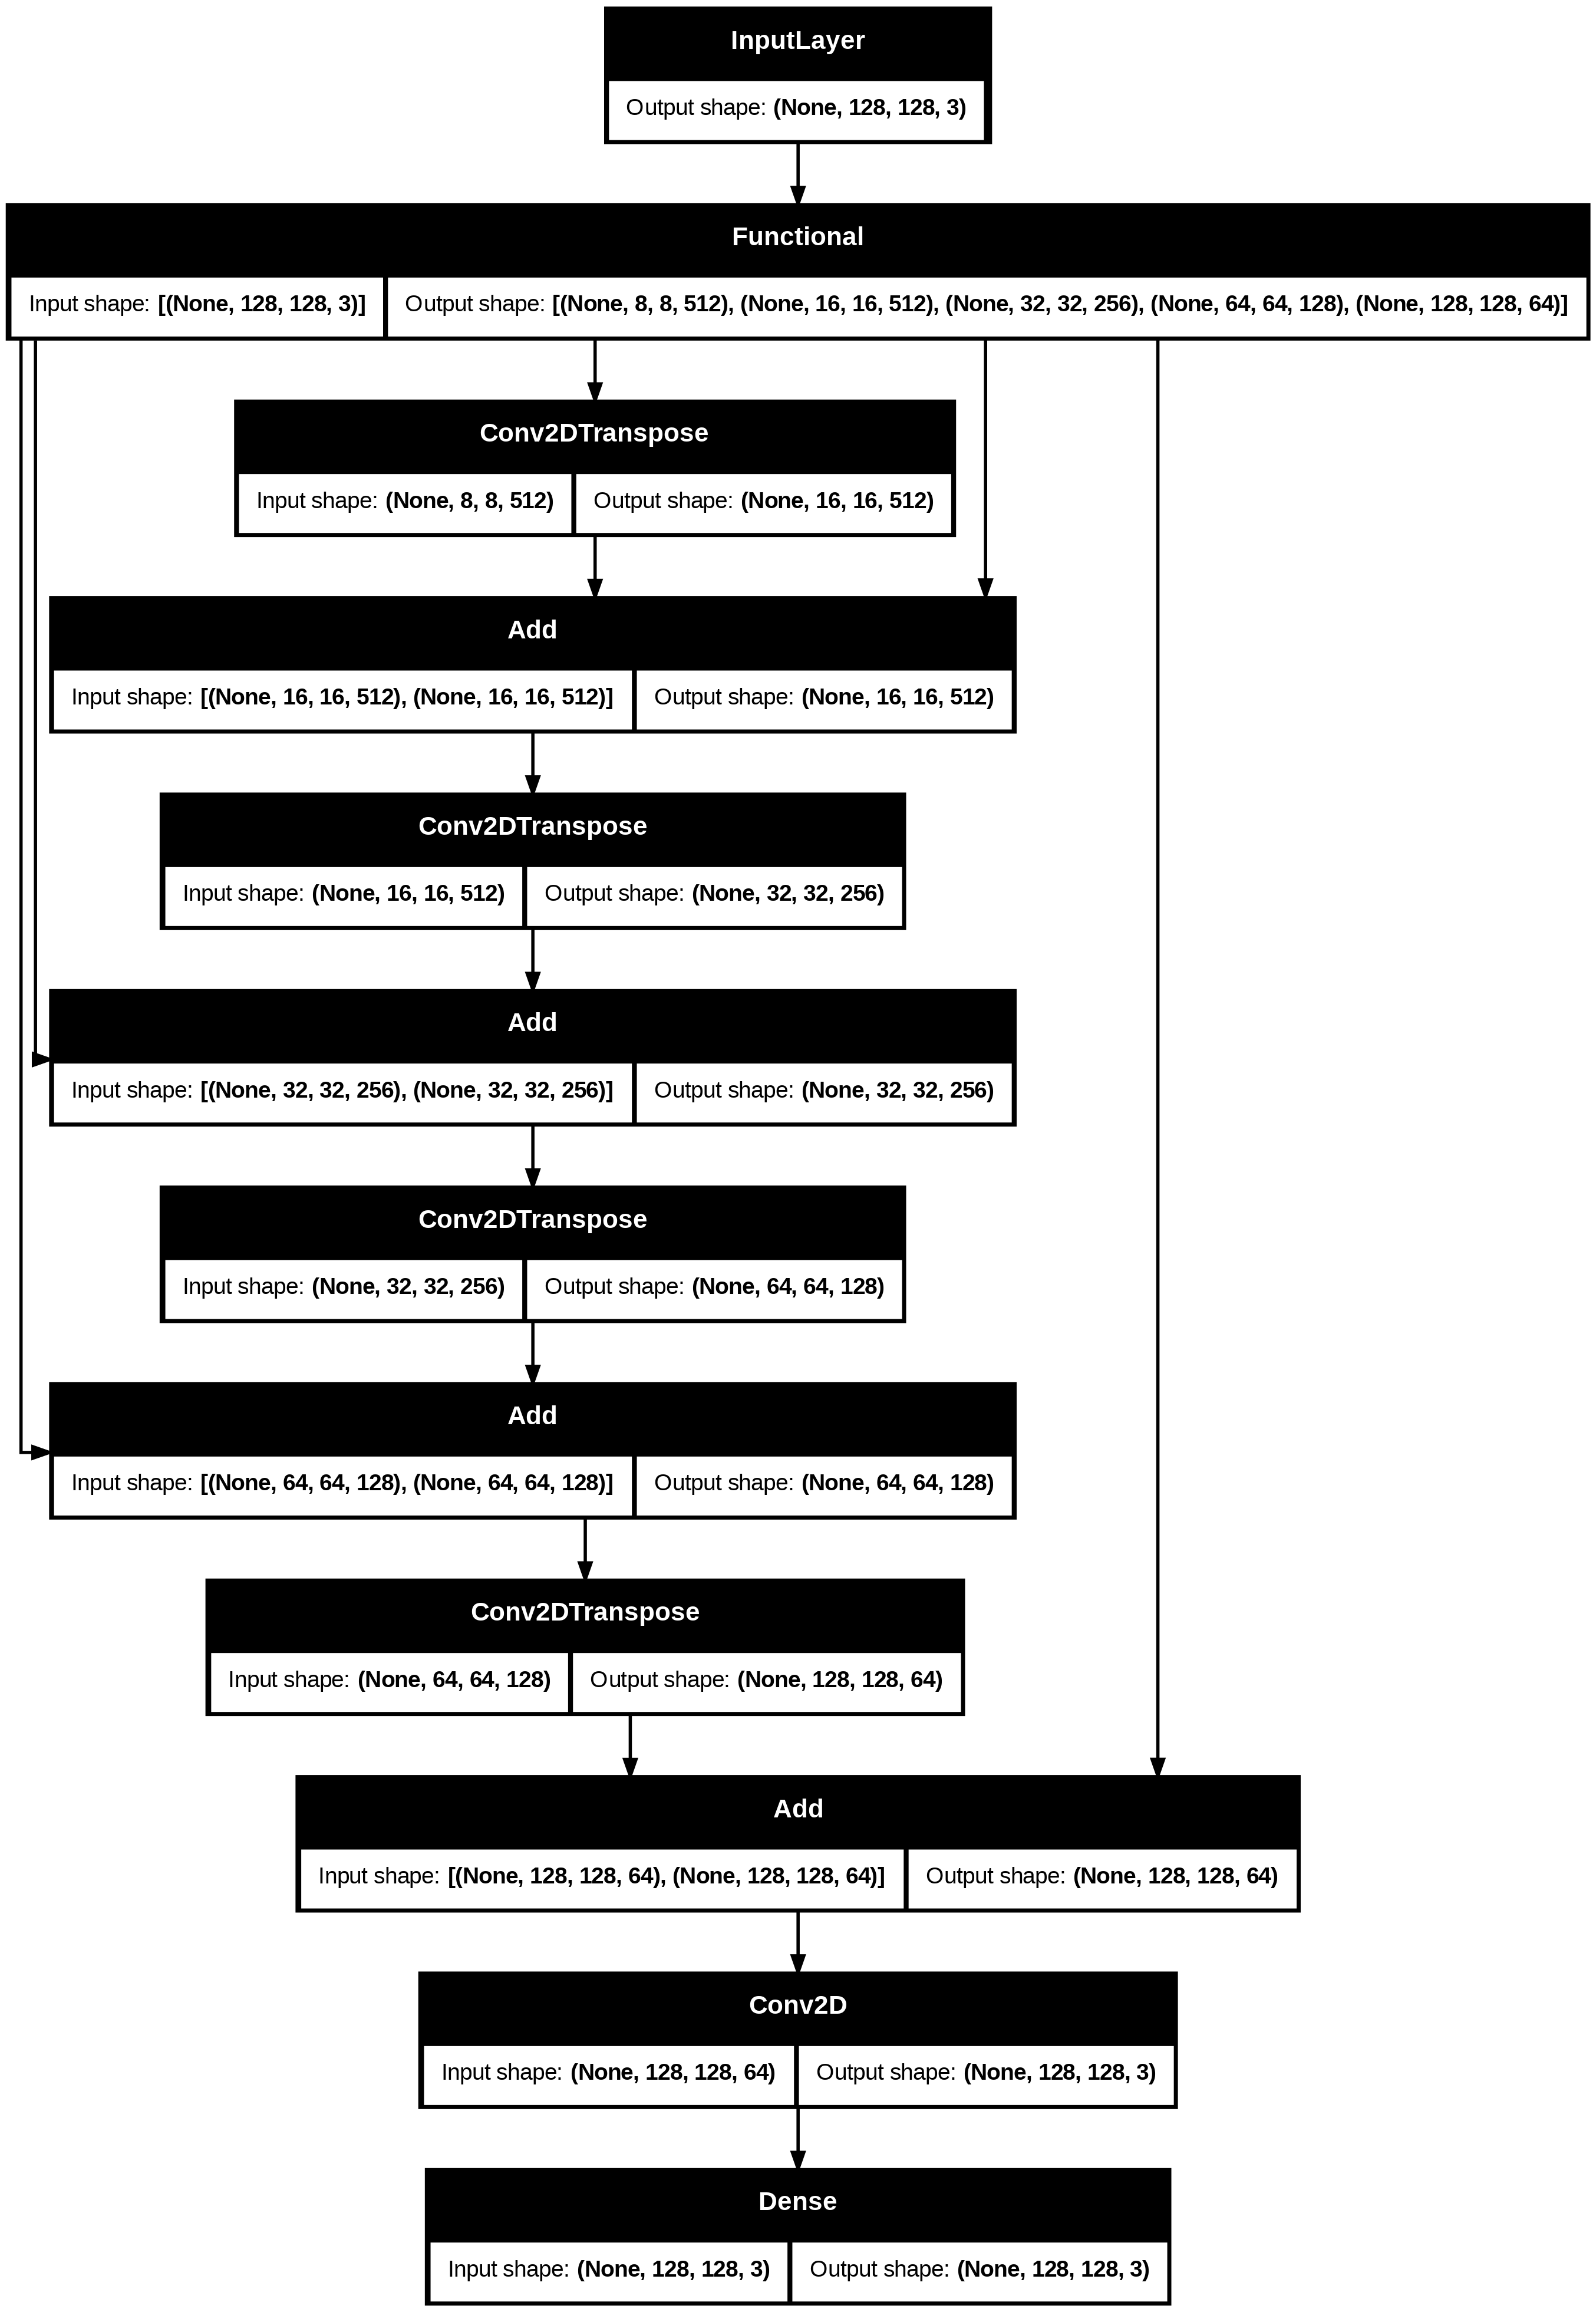

In [11]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

- 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인할 수 있음

In [12]:
# 모델 요약
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 8, 8, 512),    │     14,714,688 │ input_layer_1[0][0]    │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 32, 32, 256),   │                │                        │
│                           │ (None, 64, 64, 128),   │                │                        │
│                           │ (None, 128, 128, 64)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,359,808 │ functional[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 256)    │      1,179,904 │ add[0][0]              │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 256)    │              0 │ conv2d_transpose_1[0]… │
│                           │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        295,040 │ add_1[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64, 128)    │              0 │ conv2d_transpose_2[0]… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 64)   │         73,792 │ add_2[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 128, 128, 64)   │              0 │ conv2d_transpose_3[0]… │
│                           │                        │                │ functional[0][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 3)    │          1,731 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 128, 3)    │             12 │ conv2d[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,624,975 (71.05 MB)

 Trainable params: 3,910,287 (14.92 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1487s 6s/step - loss: 0.8897 - accuracy: 0.5491
Epoch 2/5
230/230 [==============================] - 1447s 6s/step - loss: 0.5730 - accuracy: 0.7338
Epoch 3/5
230/230 [==============================] - 1481s 6s/step - loss: 0.5253 - accuracy: 0.7624
Epoch 4/5
230/230 [==============================] - 1448s 6s/step - loss: 0.4998 - accuracy: 0.7769
Epoch 5/5
230/230 [==============================] - 1454s 6s/step - loss: 0.4851 - accuracy: 0.7843


1/1 [==============================] - 4s 4s/step


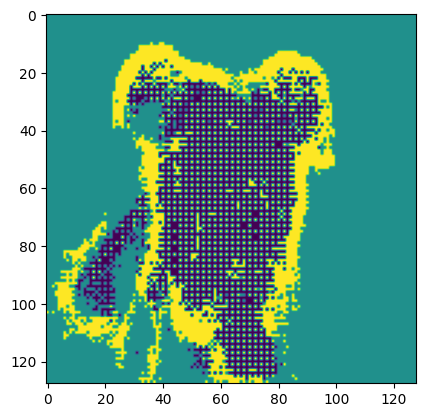

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

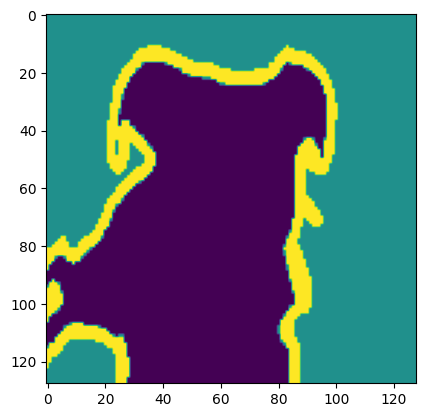

In [ ]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))